In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D  

G = 6.67430e-11  

def generate_bodies(N, mass_range=(1e20, 1e25), pos_range=(-1e11, 1e11), vel_range=(-1e3, 1e3)):
    masses = np.random.uniform(mass_range[0], mass_range[1], N)
    positions = np.random.uniform(pos_range[0], pos_range[1], (N, 3))  # 3 dimension
    velocities = np.random.uniform(vel_range[0], vel_range[1], (N, 3))
    return masses, positions, velocities

def compute_forces(masses, positions):
    N = len(masses)
    forces = np.zeros_like(positions)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            diff = positions[j] - positions[i]
            dist = np.linalg.norm(diff) + 1e-10
            force_mag = G * masses[i] * masses[j] / dist**2
            forces[i] += force_mag * diff / dist
    return forces

def nbody_step(masses, positions, velocities, dt):
    forces = compute_forces(masses, positions)
    accelerations = forces / masses[:, None]
    velocities += accelerations * dt
    positions += velocities * dt
    return positions, velocities

def animate_nbody_3d(N=10, steps=200, dt=1e5):
    masses, positions, velocities = generate_bodies(N)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim(-1.2e11, 1.2e11)
    ax.set_ylim(-1.2e11, 1.2e11)
    ax.set_zlim(-1.2e11, 1.2e11)
    scatter = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=15)
    ax.set_title("N-body Simulation (3D, CPU, Sequential)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    def update(frame):
        nonlocal positions, velocities
        positions, velocities = nbody_step(masses, positions, velocities, dt)
        scatter._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
        return scatter,

    anim = FuncAnimation(fig, update, frames=steps, interval=30, blit=False)
    anim.save("nbody_3d_cpu_sequential.gif", writer='imagemagick', fps=30)
    plt.show()


MovieWriter imagemagick unavailable; using Pillow instead.


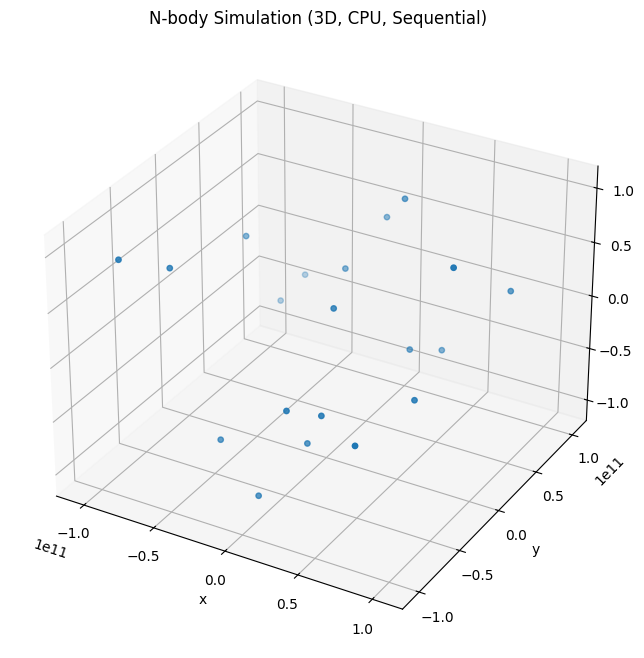

In [ ]:
if __name__ == "__main__":
   """
   So, this is what steps does: A smaller steps value → The simulation runs for a shorter time, and the animation ends sooner. 
   A larger steps value → The simulation runs longer, the bodies move more, and the animation plays for a longer time. 
   For example:
   If you set steps=100, the simulation advances only 100 steps (100 frames are shown, then the animation stops). 
   If you set steps=1000, the bodies are updated 1000 times and the animation shows 1000 frames.
   """
   animate_nbody_3d(N=20, steps=300, dt=5e4)

MovieWriter imagemagick unavailable; using Pillow instead.


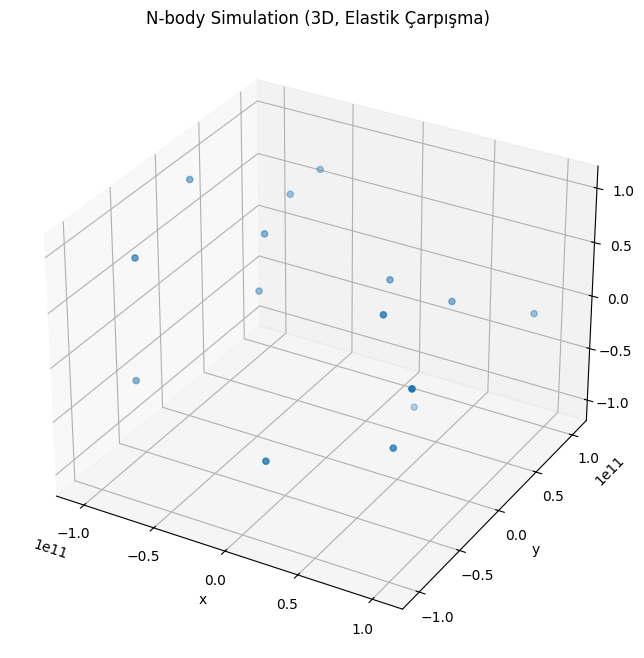

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from mpl_toolkits.mplot3d import Axes3D
G = 6.67430e-11  
def generate_bodies(N, mass_range=(1e20, 1e25), pos_range=(-1e11, 1e11), vel_range=(-1e3, 1e3)):
    masses = np.random.uniform(mass_range[0], mass_range[1], N)
    positions = np.random.uniform(pos_range[0], pos_range[1], (N, 3))
    velocities = np.random.uniform(vel_range[0], vel_range[1], (N, 3))
    return masses, positions, velocities

def compute_forces(masses, positions):
    N = len(masses)
    forces = np.zeros_like(positions)
    for i in range(N):
        for j in range(N):
            if i == j:
                continue
            diff = positions[j] - positions[i]
            dist = np.linalg.norm(diff) + 1e-10
            force_mag = G * masses[i] * masses[j] / dist**2
            forces[i] += force_mag * diff / dist
    return forces

def handle_elastic_collisions(masses, positions, velocities, radius=1e9):
    N = len(masses)
    for i in range(N):
        for j in range(i+1, N):
            diff = positions[j] - positions[i]
            dist = np.linalg.norm(diff)
            if dist < 2*radius:  
                n_hat = diff / dist
                v1, v2 = velocities[i], velocities[j]
                m1, m2 = masses[i], masses[j]

                # Separate the two vectors along the collision direction: (https://en.wikipedia.org/wiki/Elastic_collision#Two-dimensional_collision_with_two_moving_objects)
                v1_n = np.dot(v1, n_hat)
                v2_n = np.dot(v2, n_hat)

                # Only momentum and energy change along the collision direction (n_hat).
                v1_n_new = (v1_n * (m1 - m2) + 2 * m2 * v2_n) / (m1 + m2)
                v2_n_new = (v2_n * (m2 - m1) + 2 * m1 * v1_n) / (m1 + m2)

                # Update the velocities along the collision direction
                velocities[i] += (v1_n_new - v1_n) * n_hat
                velocities[j] += (v2_n_new - v2_n) * n_hat

                # Separate the bodies to avoid overlap
                overlap = 2*radius - dist
                positions[i] -= 0.5 * overlap * n_hat
                positions[j] += 0.5 * overlap * n_hat

    return positions, velocities

def nbody_step(masses, positions, velocities, dt, radius=1e9):
    forces = compute_forces(masses, positions)
    accelerations = forces / masses[:, None]
    velocities += accelerations * dt
    positions += velocities * dt
    positions, velocities = handle_elastic_collisions(masses, positions, velocities, radius)
    return positions, velocities

def animate_nbody_3d(N=10, steps=200, dt=1e5, radius=1e9):
    masses, positions, velocities = generate_bodies(N)
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    lim = 1.2e11
    ax.set_xlim(-lim, lim)
    ax.set_ylim(-lim, lim)
    ax.set_zlim(-lim, lim)
    scatter = ax.scatter(positions[:, 0], positions[:, 1], positions[:, 2], s=20)
    ax.set_title("N-body Simulation (3D, Elastic Collisions)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")

    def update(frame):
        nonlocal positions, velocities
        positions, velocities = nbody_step(masses, positions, velocities, dt, radius)
        scatter._offsets3d = (positions[:, 0], positions[:, 1], positions[:, 2])
        return scatter,

    anim = FuncAnimation(fig, update, frames=steps, interval=30, blit=False)
    anim.save("nbody_3d_elastic_collision.gif", writer='imagemagick', fps=30)
    plt.show()

if __name__ == "__main__":
    animate_nbody_3d(N=15, steps=300, dt=1e5, radius=2e9)
